In [1]:
import numpy as np

# Create monkey patches
np.float = float
np.int = int
np.object = object
np.bool = bool

In [80]:
import pandas as pd
from sklearn.model_selection import train_test_split
import gunshot_utils as utils
import importlib
import random
import torch as th
import torchaudio
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from pydub import AudioSegment
from pydub.playback import play
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm import tqdm

importlib.reload(utils)

<module 'gunshot_utils' from '/Users/borosabel/Documents/Uni/Thesis/PopMusicInformationRetrieval/gunshot_utils.py'>

In [3]:
# # This cell is only intented to create a subset of data so I can present it effectively without needing to wait too much on testing.
#
# # SAMPLE GUNSHOT DATASET
# # Load the gunshot DataFrame
# gunshot_df = pd.read_csv('./filtered_gunshot_metadata_glocks.csv')
# gunshot_df = gunshot_df[['filename', 'gunshot_location_in_seconds', 'num_gunshots']]
#
# gunshot_df['gunshot_location_in_seconds'] = gunshot_df['gunshot_location_in_seconds'].apply(
#     lambda x: utils.preprocess_gunshot_times(x, include_first_gunshot_only=True)
# ).tolist()
#
# sampled_gunshot_df = gunshot_df.sample(n=100, random_state=42)
# destination_directory = './selected_gunshots'
# os.makedirs(destination_directory, exist_ok=True)
# new_paths = []
#
# for path in sampled_gunshot_df['filename']:
#     filename = os.path.basename(path)
#     destination_path = os.path.join(destination_directory, filename)
#     shutil.copy(path, destination_path)
#     new_paths.append(destination_path)
#
# sampled_gunshot_df['filename'] = new_paths
# sampled_gunshot_df.to_pickle('./sampled_gunshot_metadata.pkl')
#
# # SAMPLE MUSIC DATASET
# # Load the music DataFrame
# music_df = pd.read_excel('/Users/borosabel/Documents/Uni/Thesis/PopMIR/Data/Excel/baseline_data_w_topics_w_features.xlsx', engine='openpyxl')
# music_df = music_df[['Path', 'Sample Rate (Hz)']]
# sampled_music_df = music_df.sample(n=100, random_state=42)
# destination_directory = './selected_music'
# os.makedirs(destination_directory, exist_ok=True)
# new_music_paths = []
#
# for path in sampled_music_df['Path']:
#     filename = os.path.basename(path)
#     destination_path = os.path.join(destination_directory, filename)
#     shutil.copy(path, destination_path)
#     new_music_paths.append(destination_path)
#
# sampled_music_df['Path'] = new_music_paths
# sampled_music_df.to_pickle('./sampled_music_metadata.pkl')

In [4]:
gunshot_df = pd.read_pickle('./sampled_gunshot_metadata.pkl')
gunshot_df = gunshot_df[['filename', 'gunshot_location_in_seconds', 'num_gunshots']]
gunshot_df.head()

,filename,gunshot_location_in_seconds,num_gunshots
15,./selected_gunshots/glock_17_9mm(16).wav,[0.07517007],2
9,./selected_gunshots/glock_17_9mm(10).wav,[1.62344671],1
201,./selected_gunshots/glock_17_9mm(665).wav,[1.75],4
82,./selected_gunshots/glock_17_9mm(91).wav,[0.14414966],2
68,./selected_gunshots/glock_17_9mm(77).wav,[1.75],1


In [5]:
music_df = pd.read_pickle('./sampled_music_metadata.pkl')
music_df = music_df[['Path', 'Sample Rate (Hz)']]
music_df.head()

,Path,Sample Rate (Hz)
428,./selected_music/Pollywanacraka.mp3,48000
930,./selected_music/Doggy Dogg World (feat. The D...,48000
781,./selected_music/Coolio - Bright as the Sun.mp3,48000
451,./selected_music/Yo! Bum Rush The Show.mp3,48000
429,./selected_music/Welcome To The Terrordome.mp3,48000


<b>At this point we have two dataframes with 100-100 audio files, one contains the gunshots and the other contains the musical pieces</b>

In [6]:
music_train_df, music_valid_df = train_test_split(music_df, test_size=0.2, random_state=42)
gunshot_train_df, gunshot_valid_df = train_test_split(gunshot_df, test_size=0.2, random_state=42)

In [7]:
print("SHAPES:")
print(f"music_train_df: {music_train_df.shape}, music_valid_df: {music_valid_df.shape}")
print(f"gunshot_train_df: {gunshot_train_df.shape}, gunshot_valid_df: {gunshot_valid_df.shape}")

SHAPES:
music_train_df: (80, 2), music_valid_df: (20, 2)
gunshot_train_df: (80, 3), gunshot_valid_df: (20, 3)


In [8]:
class GunshotDetectionCNN(nn.Module):
    def __init__(self, num_frames):
        super(GunshotDetectionCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=(3, 7))
        self.pool1 = nn.MaxPool2d(kernel_size=(3, 1))
        self.conv2 = nn.Conv2d(10, 20, kernel_size=(3, 3))
        self.pool2 = nn.MaxPool2d(kernel_size=(3, 1))

        dummy_input = th.zeros(1, 3, 80, num_frames) 
        dummy_output = self.pool2(F.relu(self.conv2(self.pool1(F.relu(self.conv1(dummy_input))))))
        output_size = dummy_output.view(-1).shape[0]

        self.fc1 = nn.Linear(output_size, 256)
        self.fc2 = nn.Linear(256, 1)
        self.dropout = nn.Dropout(0.5)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))

        # Flatten the tensor
        x = x.view(x.size(0), -1)

        x = self.dropout(F.relu(self.fc1(x)))  # Apply dropout
        x = self.sigmoid(self.fc2(x))
        return x

model = GunshotDetectionCNN(num_frames=utils.NUM_FRAMES)

In [9]:
class GunshotDataset(th.utils.data.Dataset):
    def __init__(self, music_df, gunshot_df, excerpt_len=5.0, gunshot_placement_sec=2.0, gunshot_prob=1.0, min_db=3, max_db=5, max_non_gunshot_samples=1, mean=None, std=None):
        """
        :param music_df: DataFrame containing paths to music files.
        :param gunshot_df: DataFrame containing paths to gunshot files and timing info.
        :param excerpt_len: Length of the music segment in seconds.
        :param gunshot_placement_sec: Time in seconds where to place the gunshot in the music.
        :param gunshot_prob: Probability of adding a gunshot to the segment.
        :param min_db: Minimum gain (in dB) to apply to the gunshot.
        :param max_db: Maximum gain (in dB) to apply to the gunshot.
        :param max_non_gunshot_samples: Max number of non-gunshot samples to extract when no gunshots are present.
        """
        super().__init__()
        self.music_paths = music_df['Path'].tolist()
        self.gunshot_paths = gunshot_df['filename'].tolist()
        self.gunshot_truth = gunshot_df['gunshot_location_in_seconds'].tolist()
        self.excerpt_len = excerpt_len
        self.gunshot_placement_sec = gunshot_placement_sec
        self.gunshot_prob = gunshot_prob
        self.min_db = min_db
        self.max_db = max_db
        self.max_non_gunshot_samples = max_non_gunshot_samples

    def __getitem__(self, idx):
        fn_music = self.music_paths[idx]
        add_gunshot = (np.random.rand() < self.gunshot_prob)

        if add_gunshot:
            gunshot_idx = np.random.randint(0, len(self.gunshot_paths) - 1)
            fn_gunshot = self.gunshot_paths[gunshot_idx]
            gunshot_times = self.gunshot_truth[gunshot_idx][0]
            
            music_segment, sr = utils.combine_music_and_gunshot(
                music_file=fn_music,
                gunshot_file=fn_gunshot,
                gunshot_time=gunshot_times,
                gunshot_volume_increase_dB=self.max_db,
                gunshot_placement_sec=self.gunshot_placement_sec,
                excerpt_len_sec=self.excerpt_len,
                sample_rate=utils.SAMPLING_RATE
            )
            label = 1
            spectrograms, labels = utils.preprocess_audio_train(music_segment, sr, label, gunshot_placement_sec)
        else:
            music_segment, sr = utils.extract_music_segment(
                music_file=fn_music,
                excerpt_len=self.excerpt_len,
                sample_rate=utils.SAMPLING_RATE
            )
            label = 0
            spectrograms, labels = utils.preprocess_audio_train(music_segment, sr, label)

        if not spectrograms or not labels:
            raise ValueError("Spectrograms or labels are empty after preprocessing")

        return spectrograms[0], labels[0]

    def __len__(self):
        return len(self.music_paths)

<b>When we use the GunshotDataset which contains preprocessing the audio, preprocessing the gunshot sound, below I will cut out codes from the utility functions just to show what kind of data we have during the intermediate steps.</b>

In [10]:
music_waveform, sr = torchaudio.load(music_df.iloc[0]['Path'])
if sr != utils.SAMPLING_RATE:
    print(f"Resampling music from {sr} Hz to {utils.SAMPLING_RATE} Hz. \n")
    music_waveform = torchaudio.transforms.Resample(sr, utils.SAMPLING_RATE)(music_waveform)

excerpt_len_sec = 5
excerpt_len_samples = int(excerpt_len_sec * utils.SAMPLING_RATE)
total_music_samples = music_waveform.size(1)
max_start_sample = max(0, total_music_samples - excerpt_len_samples)
start_pos_music = random.randint(0, max_start_sample)
music_segment = music_waveform[:, start_pos_music:start_pos_music + excerpt_len_samples]
utils.play_audio(music_segment, sr)

Resampling music from 48000 Hz to 44100 Hz. 



In [12]:
gunshot_filename = gunshot_df.iloc[1]['filename']
gunshot_time = gunshot_df.iloc[0]['gunshot_location_in_seconds']
pre_gunshot_time = 0.5

# First we play the nomral gunshot file
gunshot_waveform, sr_gunshot = torchaudio.load(gunshot_df.iloc[0]['filename'])

if sr_gunshot != utils.SAMPLING_RATE:
    print(f"Resampling gunshot from {sr_gunshot} Hz to {utils.SAMPLING_RATE} Hz.\n")
    gunshot_waveform = torchaudio.transforms.Resample(sr_gunshot, utils.SAMPLING_RATE)(gunshot_waveform)

# Here we just set the gunshot audio so it won't start too later than 0.5 so we can just take it, overlay on the music audio and then we know that it if we take
# frame size which is over than 0.5 seconds the gunshot will be there somewhere
gunshot_start_sample = int((gunshot_time[0] - pre_gunshot_time) * utils.SAMPLING_RATE)
gunshot_segment = gunshot_waveform[:, gunshot_start_sample:]

utils.play_audio(gunshot_segment, sr)

In [13]:
assert utils.SAMPLING_RATE == sr_gunshot, f"Expected sample rate: {utils.SAMPLING_RATE}, but got: {sr_gunshot}"

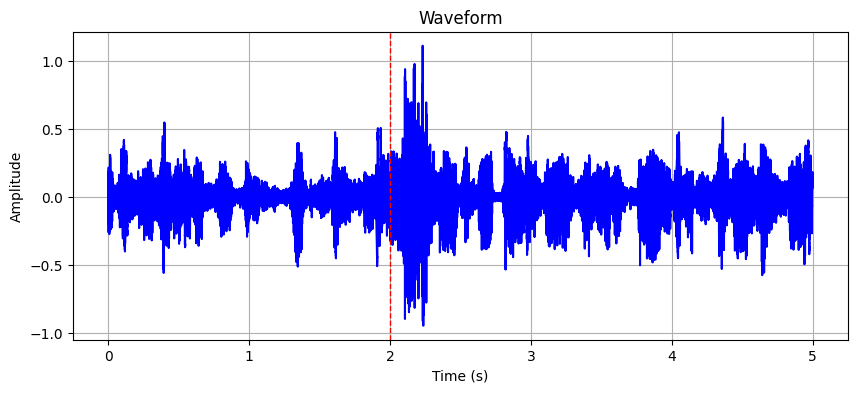

In [14]:
gunshot_placement_sec = 2
gunshot_placement_sample = int(gunshot_placement_sec * utils.SAMPLING_RATE)
combined_segment = music_segment.clone()
combined_segment[:, gunshot_placement_sample:gunshot_placement_sample + gunshot_segment.size(1)] += gunshot_segment

# Vertical line at the point where the gunshot fires
utils.plot_waveform(combined_segment, utils.SAMPLING_RATE, vertical_lines=[2])

utils.play_audio(combined_segment, utils.SAMPLING_RATE)

<b>Now we show you steps during processing this new audio we just computed above</b>

In [15]:
print(f"Currently we have a 5 second audio with shapes: {combined_segment.shape}")

Currently we have a 5 second audio with shapes: torch.Size([2, 220500])


In [16]:
segment = utils.select_gunshot_segment(combined_segment, utils.SAMPLING_RATE, 1.5)
utils.play_audio(segment, utils.SAMPLING_RATE)

In [17]:
mel_specgram = utils.calculate_melbands(segment[0], utils.SAMPLING_RATE)
print(mel_specgram.shape)

torch.Size([3, 81, 86])


In [18]:
train_dataset = GunshotDataset(music_train_df, gunshot_train_df, excerpt_len=5.0, gunshot_placement_sec=2.0, min_db=5, max_db=10, gunshot_prob=0.5)
valid_dataset = GunshotDataset(music_valid_df, gunshot_valid_df, excerpt_len=5.0, gunshot_placement_sec=2.0, min_db=5, max_db=10, gunshot_prob=0.5)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

In [19]:
device = th.device("cuda" if th.cuda.is_available() else "cpu")
use_cuda = th.cuda.is_available()

def train_model(model, optimizer, criterion, train_loader, valid_loader, epochs=10, mean=None, std=None, patience=3):
    if mean is None or std is None:
        raise ValueError("Mean and std must be provided for normalization.")

    mean = mean.to(device)
    std = std.to(device)
    model = model.to(device)
    best_score = 0.0
    epochs_since_improvement = 0

    if use_cuda:
        scaler = th.cuda.amp.GradScaler() 
    else:
        scaler = None 

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        # Add tqdm progress bar for training loop
        train_loader_tqdm = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{epochs}] Training")

        for features, labels in train_loader_tqdm:
            features, labels = features.to(device), labels.to(device).float().to(device)
            optimizer.zero_grad()
            features = (features - mean) / std

            if use_cuda:
                with th.cuda.amp.autocast():
                    outputs = model(features).view(-1)
                    loss = criterion(outputs, labels)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(features).view(-1)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

            running_loss += loss.item() * features.size(0)

            # Update tqdm description with current loss
            train_loader_tqdm.set_postfix(loss=loss.item())

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}")

        model.eval()
        val_score = evaluate_model_simple(model, valid_loader, mean, std)

        if val_score > best_score:
            best_score = val_score
            epochs_since_improvement = 0
            print(f"New best ROC AUC score: {best_score:.4f}, model saved.")
            # Save the model if desired
            # torch.save(model.state_dict(), 'best_model.pth')
        else:
            epochs_since_improvement += 1

        if epochs_since_improvement >= patience:
            print(f"No improvement in ROC AUC score for {patience} epochs. Stopping training.")
            break

    # After training, find the optimal threshold
    best_threshold = find_optimal_threshold_after_training(model, valid_loader, mean, std)

    # Compute and display the confusion matrix
    cm = compute_confusion_matrix(model, valid_loader, best_threshold, mean, std)
    display_confusion_matrix(cm)

    return best_threshold, best_score


def evaluate_model_simple(model, valid_loader, mean, std):

    all_outputs = []
    all_labels = []

    valid_loader_tqdm = tqdm(valid_loader, desc="Validation")

    with th.no_grad():
        for features, labels in valid_loader_tqdm:
            features = features.to(device)
            labels = labels.to(device).float()
            features = (features - mean) / std
            outputs = model(features).view(-1).cpu().numpy()
            all_outputs.append(outputs)
            all_labels.append(labels.cpu().numpy())

    all_outputs = np.concatenate(all_outputs)
    all_labels = np.concatenate(all_labels)
    auc = roc_auc_score(all_labels, all_outputs)
    print(f"Validation ROC AUC: {auc:.4f}")
    return auc

def find_optimal_threshold_after_training(model, valid_loader, mean, std):
    
    all_outputs = []
    all_labels = []

    # Add tqdm progress bar for validation loop
    valid_loader_tqdm = tqdm(valid_loader, desc="Finding Optimal Threshold")

    with th.no_grad():
        for features, labels in valid_loader_tqdm:
            features = features.to(device)
            labels = labels.to(device).float()
            features = (features - mean) / std
            outputs = model(features).view(-1).cpu().numpy()
            all_outputs.append(outputs)
            all_labels.append(labels.cpu().numpy())

    all_outputs = np.concatenate(all_outputs)
    all_labels = np.concatenate(all_labels)

    fpr, tpr, thresholds = roc_curve(all_labels, all_outputs)
    youdens_j = tpr - fpr
    idx = np.argmax(youdens_j)
    optimal_threshold = thresholds[idx]

    print(f"Optimal threshold found: {optimal_threshold:.4f}")
    return optimal_threshold

def compute_confusion_matrix(model, valid_loader, threshold, mean, std):
    """
    Compute confusion matrix using batch processing.

    Parameters:
        model (torch.nn.Module): The trained model.
        valid_loader (DataLoader): DataLoader for validation data.
        threshold (float): Threshold to convert probabilities to binary predictions.
        mean (torch.Tensor): Mean for normalization.
        std (torch.Tensor): Standard deviation for normalization.

    Returns:
        cm (numpy.ndarray): Confusion matrix.
    """
    all_outputs = []
    all_labels = []

    # Add tqdm progress bar for validation loop
    valid_loader_tqdm = tqdm(valid_loader, desc="Computing Confusion Matrix")

    with th.no_grad():
        for features, labels in valid_loader_tqdm:
            features = features.to(device)
            labels = labels.cpu().numpy()
            features = (features - mean) / std
            outputs = model(features).view(-1).cpu().numpy()
            all_outputs.append(outputs)
            all_labels.append(labels)

    all_outputs = np.concatenate(all_outputs)
    all_labels = np.concatenate(all_labels)

    predictions = (all_outputs >= threshold).astype(int)
    cm = confusion_matrix(all_labels, predictions)

    return cm

def display_confusion_matrix(cm):
    """
    Displays the confusion matrix using matplotlib.

    Parameters:
        cm (numpy.ndarray): Confusion matrix.
    """
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap='magma')
    plt.title('Confusion Matrix')
    plt.show()

In [20]:
mean, std = utils.compute_mean_std(train_loader)
mean = mean.to(device)
std = std.to(device)

Computing mean and std: 100%|██████████| 3/3 [00:22<00:00,  7.64s/it]


/Users/borosabel/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
Epoch [1/10] Training: 100%|██████████| 3/3 [00:23<00:00,  7.72s/it, loss=0.621]


Epoch [1/10], Loss: 0.6600


Validation: 100%|██████████| 1/1 [00:07<00:00,  7.73s/it]


Validation ROC AUC: 0.8788
New best ROC AUC score: 0.8788, model saved.


Epoch [2/10] Training: 100%|██████████| 3/3 [00:22<00:00,  7.60s/it, loss=0.543]


Epoch [2/10], Loss: 0.5299


Validation: 100%|██████████| 1/1 [00:07<00:00,  7.70s/it]


Validation ROC AUC: 0.9400
New best ROC AUC score: 0.9400, model saved.


Epoch [3/10] Training: 100%|██████████| 3/3 [00:22<00:00,  7.64s/it, loss=0.452]


Epoch [3/10], Loss: 0.4522


Validation: 100%|██████████| 1/1 [00:07<00:00,  7.61s/it]


Validation ROC AUC: 0.8485


Epoch [4/10] Training: 100%|██████████| 3/3 [00:22<00:00,  7.59s/it, loss=0.45] 


Epoch [4/10], Loss: 0.3726


Validation: 100%|██████████| 1/1 [00:07<00:00,  7.76s/it]


Validation ROC AUC: 0.8854


Epoch [5/10] Training: 100%|██████████| 3/3 [00:22<00:00,  7.61s/it, loss=0.291]


Epoch [5/10], Loss: 0.4191


Validation: 100%|██████████| 1/1 [00:07<00:00,  7.70s/it]


Validation ROC AUC: 1.0000
New best ROC AUC score: 1.0000, model saved.


Epoch [6/10] Training: 100%|██████████| 3/3 [00:22<00:00,  7.62s/it, loss=0.401]


Epoch [6/10], Loss: 0.3650


Validation: 100%|██████████| 1/1 [00:07<00:00,  7.82s/it]


Validation ROC AUC: 0.9798


Epoch [7/10] Training: 100%|██████████| 3/3 [00:22<00:00,  7.60s/it, loss=0.403]


Epoch [7/10], Loss: 0.4343


Validation: 100%|██████████| 1/1 [00:07<00:00,  7.60s/it]


Validation ROC AUC: 0.9479


Epoch [8/10] Training: 100%|██████████| 3/3 [00:22<00:00,  7.54s/it, loss=0.306]


Epoch [8/10], Loss: 0.2584


Validation: 100%|██████████| 1/1 [00:07<00:00,  7.74s/it]


Validation ROC AUC: 0.8750
No improvement in ROC AUC score for 3 epochs. Stopping training.


Finding Optimal Threshold: 100%|██████████| 1/1 [00:07<00:00,  7.58s/it]


Optimal threshold found: 0.5510


Computing Confusion Matrix: 100%|██████████| 1/1 [00:07<00:00,  7.56s/it]


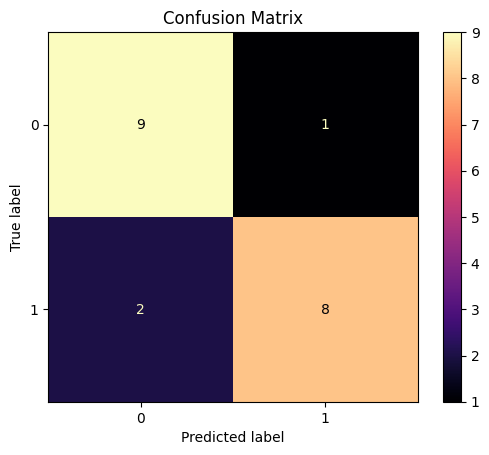

Training completed. Best ROC AUC: 1.0000, Optimal Threshold: 0.5510


In [21]:
epochs = 2
lr = 3e-4

optimizer = th.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
criterion = th.nn.BCELoss()

best_threshold, best_score = train_model(
    model, optimizer, criterion, train_loader, valid_loader,
    epochs=10, mean=mean, std=std, patience=3
)

print(f"Training completed. Best ROC AUC: {best_score:.4f}, Optimal Threshold: {best_threshold:.4f}")

In [71]:
def manual_evaluate_test(model, feature, threshold, frame_size=utils.NUM_FRAMES, sampling_rate=utils.SAMPLING_RATE, hop_length=utils.HOP_LENGTH, mean=None, std=None, step_size=None, filter_time_sec=1):
    """
    Manually evaluate the model on an audio feature, returning time positions where gunshots are detected.

    Parameters:
        model: The trained model.
        feature: The feature (e.g., spectrogram) to evaluate.
        threshold: The prediction threshold for gunshots.
        frame_size: Number of frames to use in each evaluation.
        sampling_rate: Audio sampling rate.
        hop_length: Hop length in samples for each frame.
        mean: Mean for normalization.
        std: Standard deviation for normalization.
        step_size: Step size for moving through frames (default: frame_size // 2).
        filter_time_sec: Time (in seconds) to filter out close consecutive predictions.
    
    Returns:
        List of tuples (minutes, seconds, output) where gunshots are detected along with the model's output.
    """
    if mean is None or std is None:
        raise ValueError("Mean and std must be provided for normalization.")

    mean = mean.to(device)
    std = std.to(device)
    model = model.to(device)
    model.eval()

    predictions = []
    
    feature = feature.to(device)
    feature = (feature - mean) / std

    num_frames = feature.shape[2]

    if step_size is None:
        step_size = 1

    total_iterations = 0

    with th.no_grad():
        for j in range(0, num_frames - frame_size + 1, step_size):
            total_iterations += 1
            start = j
            end = j + frame_size

            input_frame = feature[:, :, start:end].unsqueeze(0).float()
            output = model(input_frame).squeeze().item()
            predictions.append((output, start))
    
        print("Number of predictions", len(predictions))
        
        res = []
        for output, start in predictions:
            if output >= threshold:
                time_in_seconds = start * hop_length / sampling_rate
                minutes = int(time_in_seconds // 60)
                seconds = time_in_seconds % 60
                res.append((minutes, seconds, time_in_seconds, output))
                
        print("Number of results after comapring against the threshold:", len(res))
        
    filtered_res = []
    last_detection_time = -float('inf')

    for minutes, seconds, time_in_seconds, output in res:
        if time_in_seconds - last_detection_time >= filter_time_sec:
            filtered_res.append((minutes, seconds, output))
            last_detection_time = time_in_seconds

    return filtered_res

In [72]:
spectrograms, sample_rates = utils.preprocess_audio(['/Users/borosabel/Documents/Uni/Thesis/PopMIR/M.I.A. - Paper Planes.mp3'])

print(f"Got back spectogram in shape: {spectrograms[0].shape} and sample rate: {sample_rates}")

predictions = manual_evaluate_test(model, spectrograms[0], threshold=best_threshold, mean=mean, std=std, step_size=1,
                                   filter_time_sec=1.5)

if(len(predictions) > 0):
    print(f"Current treshold is {best_threshold} \n")
    
    for minutes, seconds, output in predictions:
        print(f"Detected gunshot at {minutes}m {seconds:.2f}s with model output: {output:.4f}")
else:
    print("No predictions")

100%|██████████| 1/1 [00:01<00:00,  1.57s/it]


Got back spectogram in shape: torch.Size([3, 81, 17601]) and sample rate: [44100]
Number of predictions 17516
Number of results after comapring against the threshold: 0
No predictions


<b>This is for manual checking</b>

In [76]:
def process_and_predict(model, audio_path, start_time_sec, mean, std, threshold=best_threshold):

    # Extract the waveform and the audio sample
    waveform, sample, sample_rate = utils.extract_sample_at_time(audio_path, start_time_sec)

    print(f"Playing the audio sample from {start_time_sec:.2f} seconds.")
    play(sample)

    mean = mean.to(device)
    std = std.to(device)
    model = model.to(device)
    waveform = waveform.to(device)

    mel_spectrogram = utils.calculate_melbands(waveform[0], sample_rate)
    mel_spectrogram = (mel_spectrogram - mean) / std

    # Reshape and feed to model
    with th.no_grad():
        input_tensor = mel_spectrogram.unsqueeze(0).float()
        output = model(input_tensor).squeeze().item()

    if output >= threshold:
        prediction = "Gunshot"
    else:
        prediction = "No Gunshot"

    print(f"Model Prediction: {prediction} with output: {output}")
    return prediction

audio_path = './M.I.A. - Paper Planes.mp3'
# audio_path = '''./2Pac - Hit 'Em Up (Dirty) (Music Video) HD.mp3'''
# audio_path = './50 Cent - Many Men (Wish Death) (Dirty Version).mp3'

prediction = process_and_predict(model, audio_path, start_time_sec=44.4, mean=mean, std=std)

0.55103946
Playing the audio sample from 44.40 seconds.


Input #0, wav, from '/var/folders/99/617f3z715_g8nc26tll89ddc0000gn/T/tmp1zqfo1ui.wav':
  Duration: 00:00:00.99, bitrate: 1411 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 44100 Hz, 2 channels, s16, 1411 kb/s



Model Prediction: No Gunshot with output: 0.03707350417971611
